### 校正图像畸变

In [1]:
import pickle
import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import ad_lane.ad_lane_lines as al

In [2]:
mtx, dist = al.calibrate_camera(9, 6, 'camera_cal/calibration*.jpg')

In [3]:
file_para = open( 'calibration_parameters.pkl', 'wb' )
cal_para = {'mtx': mtx, 'dist': dist}
pickle.dump(cal_para, file_para)
file_para.close()

In [4]:
file_para = open( 'calibration_parameters.pkl', 'rb' )
dist_pickle = pickle.load( file_para )
mtx = dist_pickle['mtx']
dist = dist_pickle['dist']
file_para.close()

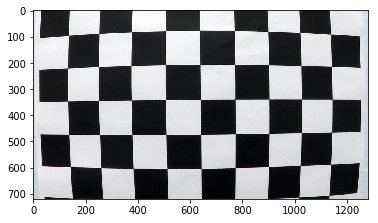

In [5]:
# Read in an image
img = cv2.imread('camera_cal/calibration1.jpg')
plt.imshow(img)

In [6]:
# 调用函数
undistorted = al.cal_undistorted(img, mtx, dist)

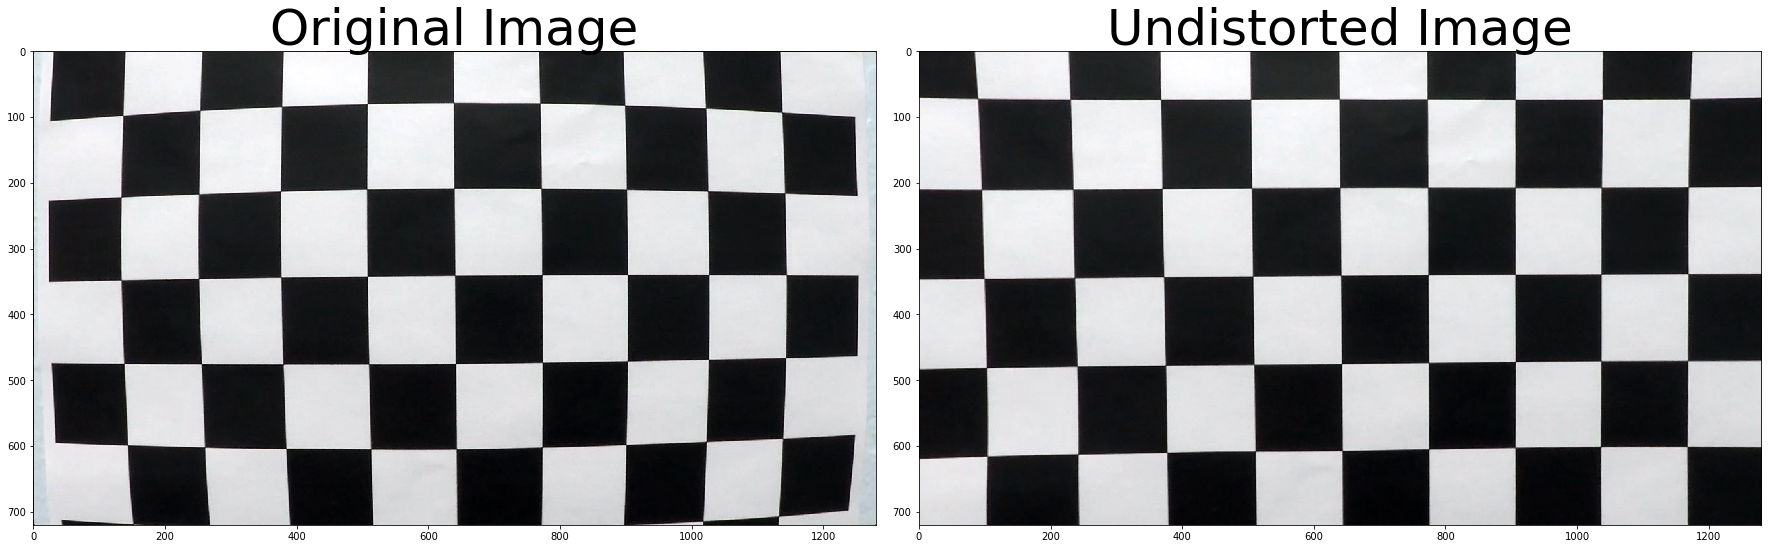

In [7]:
# 绘图，验证结果
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

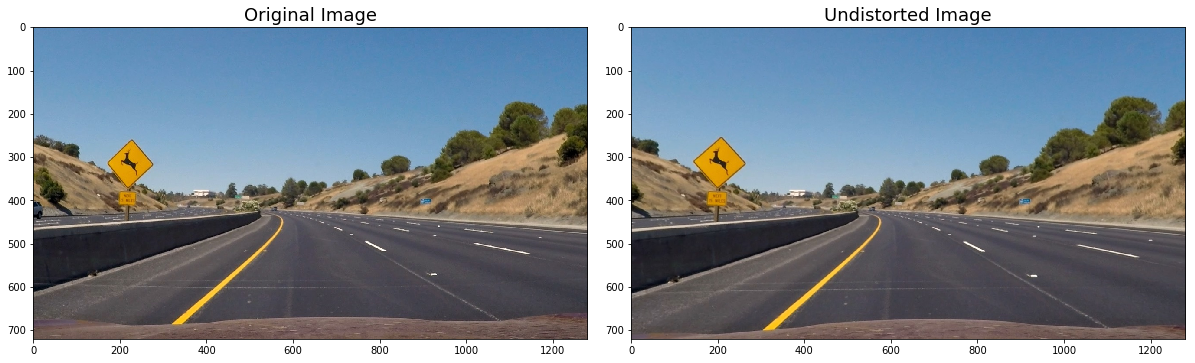

In [8]:
origin_img = cv2.imread('test_images/test2.jpg')
test_img = al.cal_undistorted(origin_img, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(origin_img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=18)
ax2.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
ax2.set_title('Undistorted Image', fontsize=18)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

### 透视转换

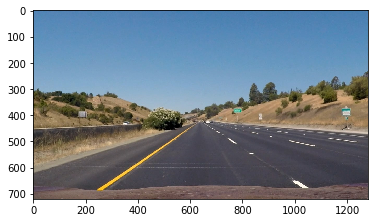

In [9]:
# 读取直线车道线
img = mpimg.imread('test_images/straight_lines1.jpg')
plt.imshow(img)

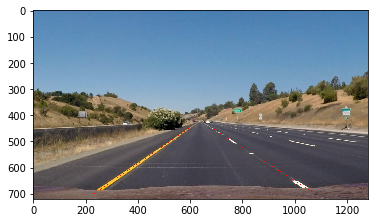

In [10]:
# 设置矩形的顶点
trape = np.array([[232, 700], [596, 450], [685, 450], [1078, 700]], np.int32)
trape = trape.reshape(-1, 1, 2)
color = (255, 0, 0)  # 红色
thickness = 1
# true 的含义是闭合
img_trape = cv2.polylines(img, [trape], True, color, thickness)
plt.imshow(img_trape)

In [11]:
src = np.float32(np.reshape(trape, (-1, 2)))
src

array([[ 232.,  700.],
       [ 596.,  450.],
       [ 685.,  450.],
       [1078.,  700.]], dtype=float32)

In [12]:
dst = np.float32([[350, 700], [350, 0], [950, 0], [950, 700]])
dst

array([[350., 700.],
       [350.,   0.],
       [950.,   0.],
       [950., 700.]], dtype=float32)

In [13]:
img_size = (img.shape[1], img.shape[0])  # 先是宽度，再是高度
img_size

(1280, 720)

In [14]:
# 求透视的转换矩阵
M = cv2.getPerspectiveTransform(src, dst)
M

array([[-4.71105528e-01, -1.51805905e+00,  9.39447236e+02],
       [ 2.10921777e-16, -1.85992462e+00,  8.36966080e+02],
       [ 3.31491003e-19, -2.37751256e-03,  1.00000000e+00]])

In [15]:
# 求透视的逆转转换矩阵
M_back = cv2.getPerspectiveTransform(dst, src)
M_back

array([[ 1.48333333e-01, -8.16561972e-01,  5.44083333e+02],
       [-5.98351777e-17, -5.37656197e-01,  4.50000000e+02],
       [-0.00000000e+00, -1.27828436e-03,  1.00000000e+00]])

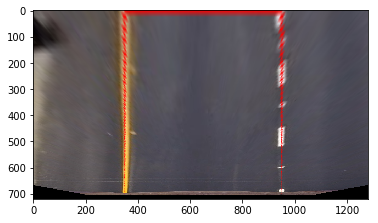

In [16]:
# 透视图片
img_warped = cv2.warpPerspective(img_trape, M, img_size)
plt.imshow(img_warped)

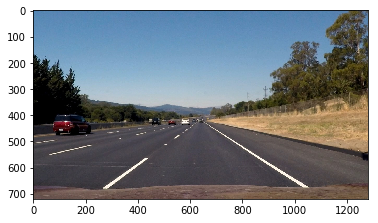

In [17]:
# 验证
# 读取直线车道线
img = mpimg.imread('test_images/straight_lines2.jpg')
plt.imshow(img)

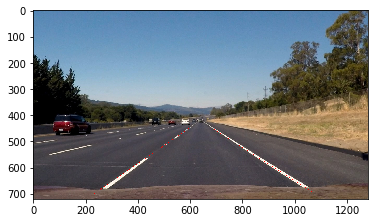

In [18]:
# 设置矩形的顶点
trape = np.array([[232, 700], [596, 450], [685, 450], [1078, 700]], np.int32)
trape = trape.reshape(-1, 1, 2)
color = (255, 0, 0)  # 红色
thickness = 1

# true 的含义是闭合
img_trape = cv2.polylines(img, [trape], True, color, thickness)
plt.imshow(img_trape)

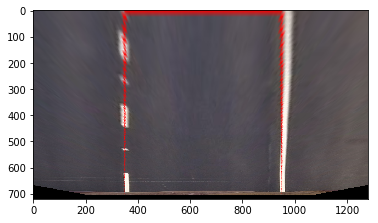

In [19]:
# 透视图片
img_warped = cv2.warpPerspective(img_trape, M, img_size)
plt.imshow(img_warped)

In [20]:
# 保存M值
file_para = open( 'perspective_parameters.pkl', 'wb' )
warp_para = {'M': M, 'M_back':M_back}
pickle.dump(warp_para, file_para)
file_para.close()

In [21]:
file_para = open( 'perspective_parameters.pkl', 'rb' )
dist_pickle = pickle.load( file_para )
M = dist_pickle['M']
M_back = dist_pickle['M_back']
file_para.close()

In [22]:
img_size = (test_img.shape[1], test_img.shape[0])  # 先是宽度，再是高度
wrap_img= cv2.warpPerspective(test_img, M, img_size)

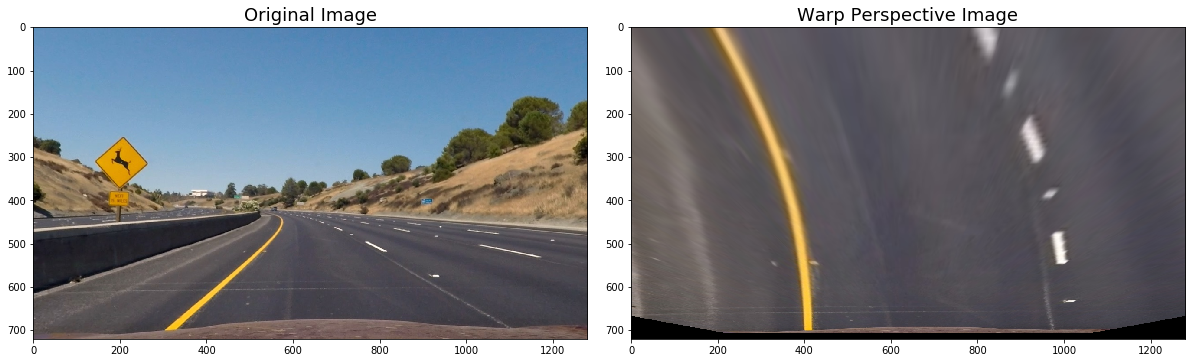

In [23]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
f.tight_layout()
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=18)
wrap_img = cv2.cvtColor(wrap_img, cv2.COLOR_BGR2RGB)
ax2.imshow(wrap_img)
ax2.set_title('Warp Perspective Image', fontsize=18)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

### 颜色甄别车道

Text(0.5,1,'Sobel_x_filter')

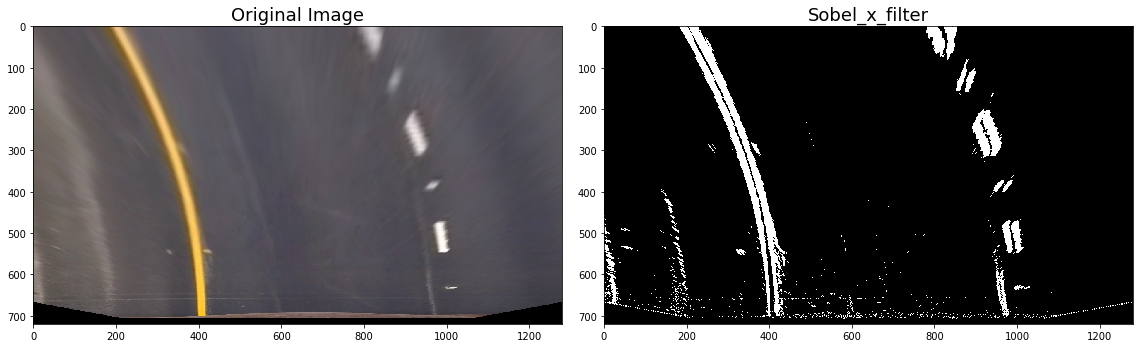

In [24]:
# Apply each of the thresholding functions
gradx = al.abs_sobel_thresh(wrap_img, orient='x', sobel_kernel=3, thresh=(10, 230))

# Plot the result
f, (axs1, axs2) = plt.subplots(1, 2, figsize=(16, 9))
f.tight_layout()
axs1.imshow(wrap_img)
axs1.set_title('Original Image', fontsize=18)
axs2.imshow(gradx, cmap='gray')
axs2.set_title('Sobel_x_filter', fontsize=18)

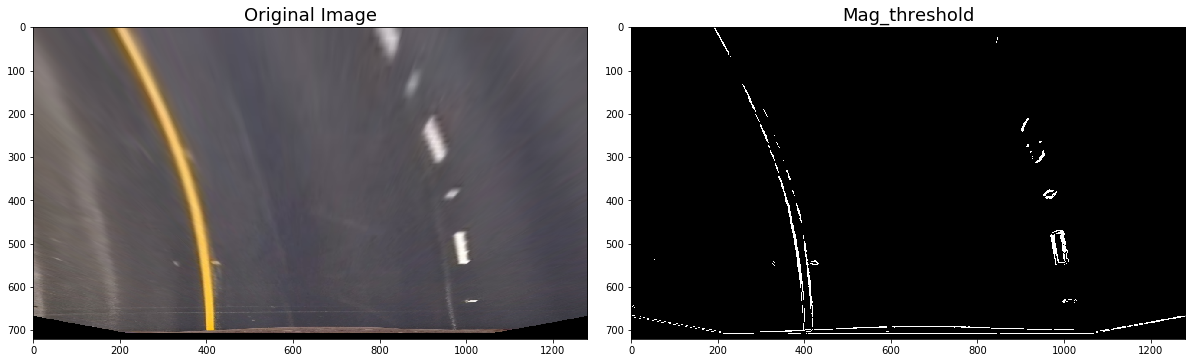

In [25]:
mag_binary = al.mag_thresh(wrap_img, sobel_kernel=9, thresh=(50, 100))

# Plot the result
f, (axs1, axs2) = plt.subplots(1, 2, figsize=(16, 9))
f.tight_layout()
axs1.imshow(wrap_img)
axs1.set_title('Original Image', fontsize=18)
axs2.imshow(mag_binary, cmap='gray')
axs2.set_title('Mag_threshold', fontsize=18)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

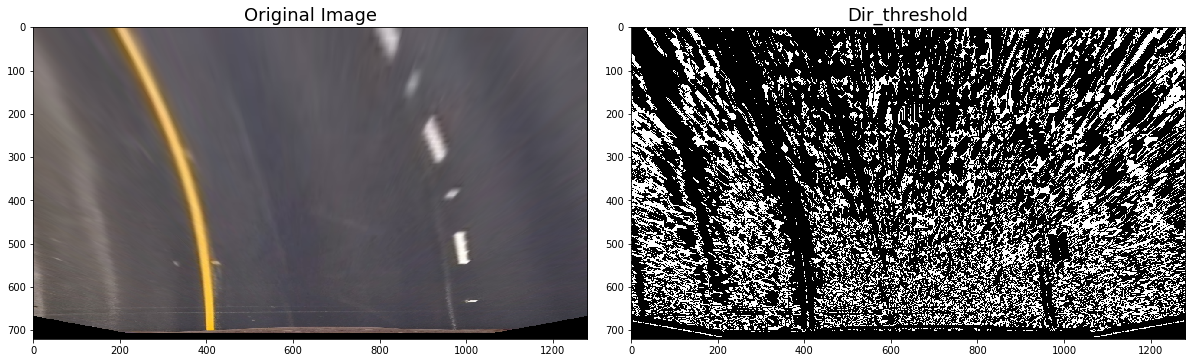

In [26]:
dir_binary = al.dir_threshold(wrap_img, sobel_kernel=21, thresh=(0.7, 1.3))

# Plot the result
f, (axs1, axs2) = plt.subplots(1, 2, figsize=(16, 9))
f.tight_layout()
axs1.imshow(wrap_img)
axs1.set_title('Original Image', fontsize=18)
axs2.imshow(dir_binary, cmap='gray')
axs2.set_title('Dir_threshold', fontsize=18)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

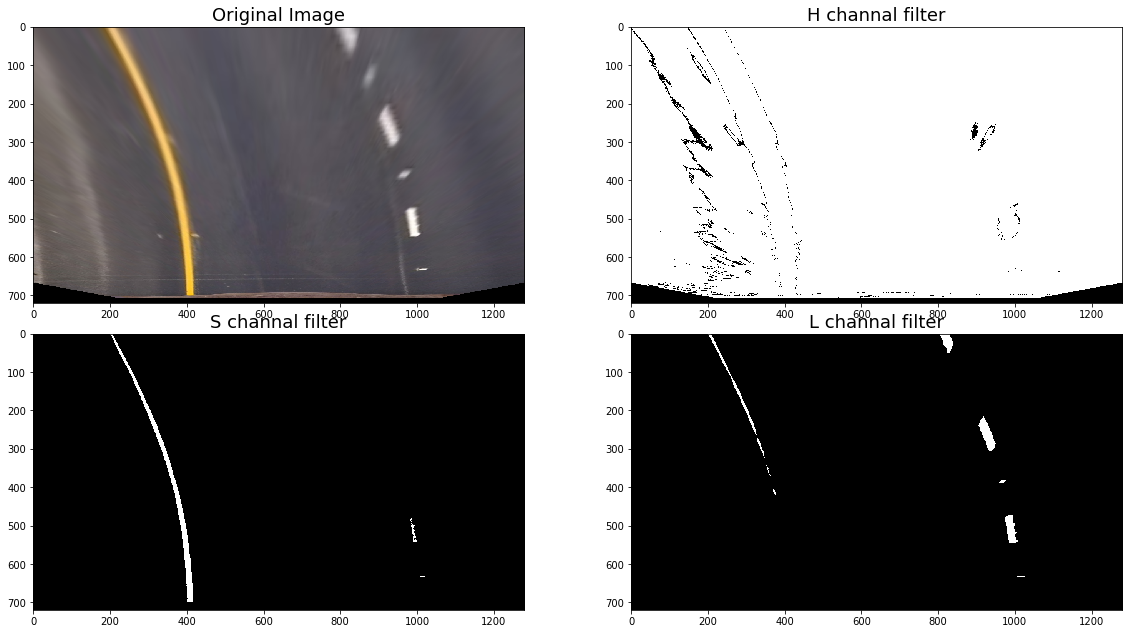

In [27]:
l_binary = al.hls_select(wrap_img, channel='L', thresh=(180, 255))
s_binary = al.hls_select(wrap_img, channel='S', thresh=(180, 255))
h_binary = al.hls_select(wrap_img, channel='H', thresh=(0, 255))

f, axs = plt.subplots(2, 2, figsize=(16, 9))
f.tight_layout()
axs[0, 0].imshow(wrap_img)
axs[0, 0].set_title('Original Image', fontsize=18)
axs[0, 1].imshow(h_binary, cmap='gray')
axs[0, 1].set_title('H channal filter', fontsize=18)
axs[1, 0].imshow(s_binary, cmap='gray')
axs[1, 0].set_title('S channal filter', fontsize=18)
axs[1, 1].imshow(l_binary, cmap='gray')
axs[1, 1].set_title('L channal filter', fontsize=18)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

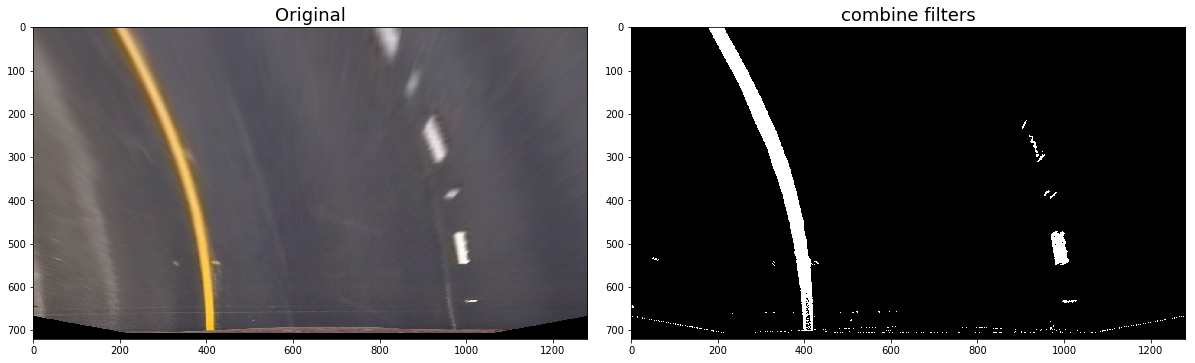

In [28]:
binary = al.combine_filters(wrap_img)

f, axs = plt.subplots(1, 2, figsize=(16, 9))
f.tight_layout()
axs[0].imshow(wrap_img)
axs[0].set_title('Original', fontsize=18)
axs[1].imshow(binary, cmap='gray')
axs[1].set_title('combine filters', fontsize=18)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

### 车道线识别

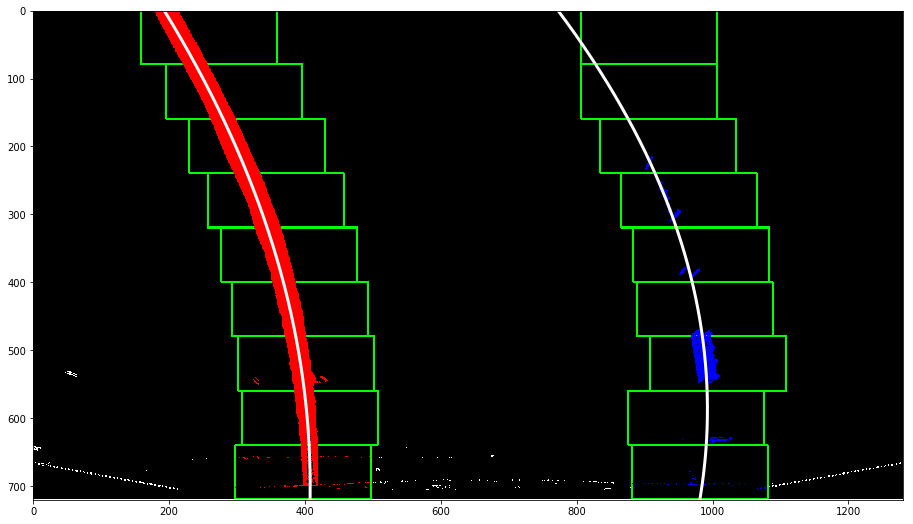

In [29]:
left_fit, right_fit, out_img = al.find_line_fit(binary)
left_fitx, right_fitx, ploty = al.get_fit_xy(binary, left_fit, right_fit)

fig = plt.figure(figsize=(16, 9))
plt.imshow(out_img)
#绘制左侧车道线的方程
plt.plot(left_fitx, ploty, color='white', linewidth=3.0)
#绘制右侧车道线的方程
plt.plot(right_fitx, ploty, color='white',  linewidth=3.0)
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

### 计算实际的曲率

In [30]:
curvature, distance_from_center = al.cal_cur_and_pos(binary, left_fitx, right_fitx, ploty)

In [31]:
curvature

315.8868393352774

In [32]:
distance_from_center

0.35148321152316075

### 合成图片

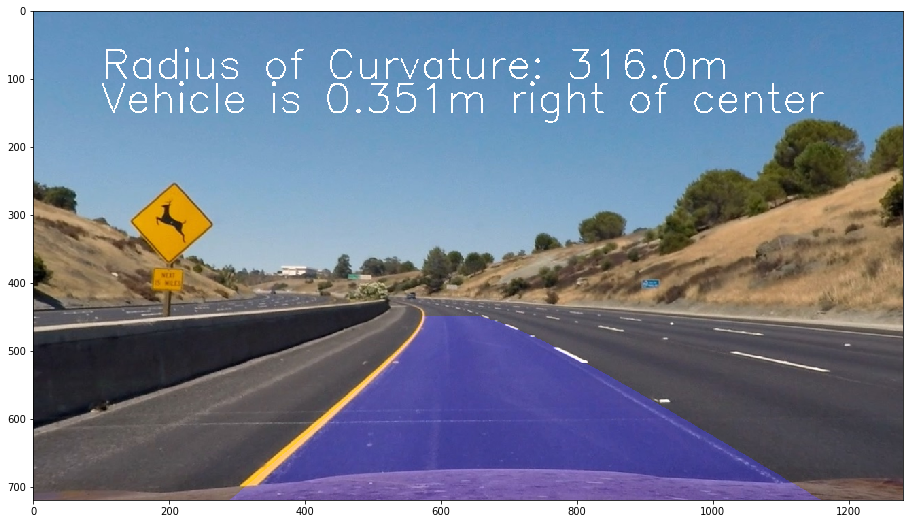

In [33]:
result = al.image_add(binary, test_img, left_fitx, right_fitx, ploty, M_back)
result = al.draw_values(result, curvature, distance_from_center)
fig = plt.figure(figsize=(16, 9))
plt.imshow(result)